# Scaling Relations:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM


These public binary SMDPL-UM data can be downloaded from [Peter Behroozi's website](https://halos.as.arizona.edu/UniverseMachine/DR1/SMDPL_SFR/)

In [2]:
dtype = np.dtype(dtype=[('id', 'i8'),('descid','i8'),('upid','i8'),
                        ('flags', 'i4'), ('uparent_dist', 'f4'),
                        ('pos', 'f4', (6)), ('vmp', 'f4'), ('lvmp', 'f4'),
                        ('mp', 'f4'), ('m', 'f4'), ('v', 'f4'), ('r', 'f4'),
                        ('rank1', 'f4'), ('rank2', 'f4'), ('ra', 'f4'),
                        ('rarank', 'f4'), ('A_UV', 'f4'), ('sm', 'f4'), 
                        ('icl', 'f4'), ('sfr', 'f4'), ('obs_sm', 'f4'), 
                        ('obs_sfr', 'f4'), ('obs_uv', 'f4'), ('empty', 'f4')],
                 align=True)

halos = np.fromfile('/Volumes/Hasti-2T-2/main/SMDPL/sfr_catalog_0.258000.bin', dtype=dtype)


In [3]:
sfr = halos["sfr"] #[Msun/yr]
pos = halos['pos'] #[comoving Mpc/h]

In [4]:
# Intrinsic Luminosity for LAEs:
L_int_Lya = 1.1e42 * sfr  #erg/s

In [5]:
# 1. Luminosity cut --> depends to the flux limit of the survey.
# 2. Making sure the objects are inside the 400 [Mpc/h] cubic box. --> to make sure we have a cubic volume.

mask = (L_int_Lya >= 10**(41)) & (pos[:,0] < 400) & (pos[:,0] > 0) & (pos[:,1] < 400) & (pos[:,1] > 0) & (pos[:,2] < 400) & (pos[:,2] > 0)


In [6]:
# Deleting the quantities that we don't need.
del sfr, pos

In [7]:
def rvir_to_galaxysize(redshift, r, sigma):
    """
    Converts the halo virial radius to the galaxy size using Kravtsov (2012) relation for a fixed cosmology.
    
    Inputs:
    -------
    redshift
    r --> halo virial radius (array: (shape=(N,)) --> [unit: comoving kpc/h]
    sigma --> scatter
    
    Returns:
    --------
    guassian random values for galaxy size with the mean r_half=0.015*R_krav (from Kravtsov (2012)) and scatter of sigma dex
    (array: (shape=(N,)) --> [unit: comoving kpc/h]
       
    """
    
    # unit definition
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)
    littleh = cosmo.H0.value/100.
    kpcph = u.def_unit('kpcph', u.kpc/littleh) #[kpc/h]
    
    # Kravtsov (2012) relation
    R_krav = (((r * kpcph).to(u.kpc)) / (1 + redshift)).value
    r_half = R_krav * 0.015  
    log_r_half = np.log10(R_krav) + np.log10(0.015)
    
    # generating Gaussian random
    mu_r_half = log_r_half
    sigma_r_half = np.random.normal(sigma, 0.01, len(r))
    sample_r_half = np.random.normal(mu_r_half, sigma_r_half, len(r))
    
    return sample_r_half

**Esample:**

In [8]:
%%time
a = 0.258000  #the scale factor is shown in the name of the data:  "sfr_catalog_0.258000.bin"
redshift = (1/a) -1
sigma = 0.2
r = halos["r"][mask] #[ckpc/h]

sample_r_half_values = rvir_to_galaxysize(redshift, r, sigma)

CPU times: user 338 ms, sys: 7.34 s, total: 7.68 s
Wall time: 51.1 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 48.1 ms, sys: 23 ms, total: 71.2 ms
Wall time: 297 ms


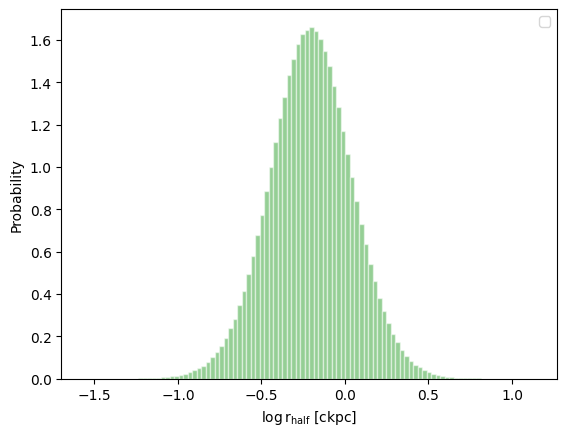

In [9]:
%%time

plt.hist(sample_r_half_values, bins=100, density=True, histtype='bar', ec='white', facecolor='C2', alpha=0.5)
plt.ylabel("Probability")
plt.xlabel(r'$\rm{log}\,r_{\rm{half}}\,\,[ckpc]$')
plt.legend()

In [10]:
def ssfr_to_mcold(sm, sfr, sigma):
    """
    Converts sSFR=SFR/M∗ (specific star formation rate) to mcold (cold gas mass) using Dave et al (2016) relation for a fixed cosmology.
    
    Note: make sure your SFR and SM arrays are not including zero values, if this is the case change them with a very small value loke 1e-15:
    sfr[sfr==0] = 1e-15
    sm[sm==0] = 1e-15
    
    Inputs:
    -------
    sm --> stellar mass (array: (shape=(N,)) --> [unit: Msun]
    sfr --> star formation rate (array: (shape=(N,)) --> [unit: Msun/yr]
    sigma --> scatter
    
    Returns:
    --------
    guassian random values for mcold with a scatter of sigma dex
    (array: (shape=(N,)) --> [unit: Msun/h]
       
    """
    
    # unit definition
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)
    littleh = cosmo.H0.value/100.
    Msunph = u.def_unit('Msunph', u.Msun/littleh) #[Msun/h]

    
    # Convert units to Msun/h and Msun/h/Gyr
    sm_h = ((sm*u.Msun).to(Msunph)).value  #Msun/h
    sfr_h_Gyr = ((sfr*u.Msun/u.yr).to(Msunph/u.Gyr)).value

    
    # Calculate log_M_cold
    log_M_cold = (1/2) * np.log10(sfr_h_Gyr) + (1/2) * np.log10(sm_h) + 2
    
    # Generate Gaussian random values for sigma
    sigma_M_cold = np.random.normal(sigma, 0.001, len(sfr))
    
    # Generate Gaussian random values for M_cold with the calculated mean and sigma
    sample_M_cold = np.random.normal(log_M_cold, sigma_M_cold, len(sfr))
    
    
    return sample_M_cold


**Esample:**

In [11]:
%%time

sfr = halos["sfr"][mask] #[Msun/yr]
sm = halos["sm"][mask] #[Msun] 

# to avoid log(zero)
sfr[sfr==0] = 1e-15
sm[sm==0] = 1e-15


CPU times: user 307 ms, sys: 1.9 s, total: 2.21 s
Wall time: 4.78 s


In [12]:
%%time
sigma =0.01

sample_M_cold_values = ssfr_to_mcold(sm, sfr, sigma)

CPU times: user 160 ms, sys: 35.3 ms, total: 195 ms
Wall time: 274 ms


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 72.6 ms, sys: 20.3 ms, total: 92.9 ms
Wall time: 101 ms


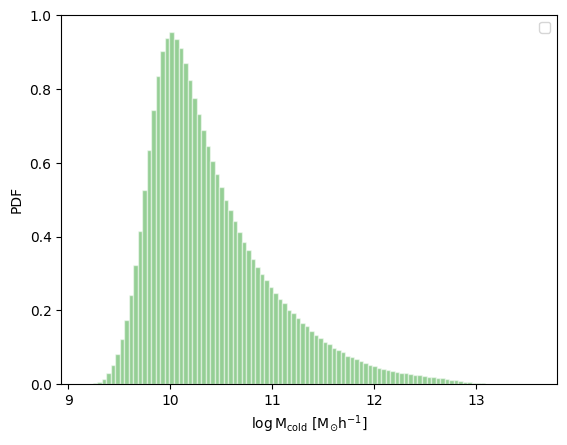

In [13]:
%%time
plt.hist(sample_M_cold_values, bins=100, density = True, histtype='bar', ec='white', facecolor='C2', alpha=0.5)

plt.ylabel("PDF")
plt.xlabel(r'$\rm{log}\,M_{\rm{cold}}\,\,[M_{\odot}h^{-1}]$')
plt.legend()


In [14]:
def sm_to_zcold(sm, sigma):
    """
    Converts M∗ (stellar mass) to zcold (metallicity of the cold gas) using Guo et al (2016) relation for a fixed cosmology.
    
    Note: make sure your SM array ia not including zero values, if this is the case change them with a very small value loke 1e-15:
    sm[sm==0] = 1e-15
    
    Inputs:
    -------
    sm --> stellar mass (array: (shape=(N,)) --> [unit: Msun]
    sigma --> scatter
    
    Returns:
    --------
    guassian random values for zcold with a scatter of sigma dex
    (array: (shape=(N,)) --> [unit: Msun/h]
       
    """
    # From Guo et al 2016:
    Z_cold = 1e-12*(sm)**(0.067) 
    log_z_cold_in_z_sun_unit = -12 + 0.97*np.log10(sm) + 1.7
    
    # Generate Gaussian random values
    mu_log_z_cold = log_z_cold_in_z_sun_unit
    sigma_Z_cold = np.random.normal(sigma,0.01,len(sfr))  # generating guassian random values for sigma with the mean 0.1
    sample_Z_cold = np.random.normal(mu_log_z_cold, sigma_Z_cold, len(sm)) # generating guassian random values for r_half with the mean r_half=0.015*R_krav and sigma

    
    return sample_Z_cold


**Esample:**

In [15]:
%%time
sigma =0.1

sample_Z_cold_values = sm_to_zcold(sm, sigma)

CPU times: user 168 ms, sys: 27.4 ms, total: 196 ms
Wall time: 206 ms


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 68.6 ms, sys: 7.78 ms, total: 76.4 ms
Wall time: 75.9 ms


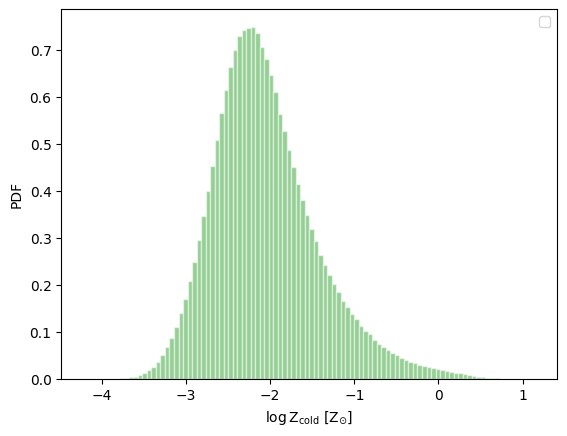

In [16]:
%%time
plt.hist(sample_Z_cold_values, bins=100, density = True, histtype='bar', ec='white', facecolor='C2', alpha=0.5)


plt.ylabel("PDF")
plt.xlabel(r'$\rm{log}\,Z_{\rm{cold}}\,\,[Z_{\odot}]$')
plt.legend()

In [17]:
# creating a new catalog containing new scaling relations:

In [18]:
dtype_new = np.dtype(dtype=[('id', 'i8'),('descid','i8'),('upid','i8'),
                        ('flags', 'i4'), ('uparent_dist', 'f4'),
                        ('pos', 'f4', (6)), ('vmp', 'f4'), ('lvmp', 'f4'),
                        ('mp', 'f4'), ('m', 'f4'), ('v', 'f4'), ('r', 'f4'),
                        ('rank1', 'f4'), ('rank2', 'f4'), ('ra', 'f4'),
                        ('rarank', 'f4'), ('A_UV', 'f4'), ('sm', 'f4'), 
                        ('icl', 'f4'), ('sfr', 'f4'), ('obs_sm', 'f4'), 
                        ('obs_sfr', 'f4'), ('obs_uv', 'f4'), 
                        ('size', 'f4'), ('mcold', 'f4'), ('zcold', 'f4'), ('empty', 'f4')],
                 align=True)


In [19]:
%%time

# Create a structured array using the dtypes above
data = np.empty(len(sample_r_half_values), dtype=dtype_new)

# Assign values to the structured array fields
data["id"] = halos["id"][mask]
data["descid"] = halos["descid"][mask]
data["upid"] = halos["upid"][mask]
data["flags"] = halos["flags"][mask]
data["uparent_dist"] = halos["uparent_dist"][mask]
data["pos"] = halos["pos"][mask]
data["vmp"] = halos["vmp"][mask]
data["lvmp"] = halos["lvmp"][mask]
data["mp"] = halos["mp"][mask]
data["m"] = halos["m"][mask]
data["v"] = halos["v"][mask]
data["r"] = halos["r"][mask]
data["rank1"] = halos["rank1"][mask]
data["rank2"] = halos["rank2"][mask]
data["ra"] = halos["ra"][mask]
data["rarank"] = halos["rarank"][mask]
data["A_UV"] = halos["A_UV"][mask]
data["sm"] = halos["sm"][mask]
data["icl"] = halos["icl"][mask]
data["sfr"] = halos["sfr"][mask]
data["obs_sm"] = halos["obs_sm"][mask]
data["obs_sfr"] = halos["obs_sfr"][mask]
data["obs_uv"] = halos["obs_uv"][mask]
data["size"] = sample_r_half_values
data["mcold"] = sample_M_cold_values
data["zcold"] = sample_Z_cold_values
data["empty"] = halos["empty"][mask]

# Save the structured array as a .npy file
np.save("sfr_catalog_0.258000_w_scaling_relations_masked_L41_pos400.npy", data)



CPU times: user 3.22 s, sys: 3.3 s, total: 6.52 s
Wall time: 11.2 s
